# lgb stacking

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import io
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [4]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [5]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_author')
feedMe_dir = main_path / 'feed_me' 
medium_dir =  main_path / 'medium' 

feature_dir = medium_dir / 'feat'
val_dir = medium_dir / 'val'
tst_dir = medium_dir / 'tst'
sub_dir =  main_path / 'result' 

trn_file = feedMe_dir / 'train.csv'
tst_file = feedMe_dir / 'test_x.csv'
sample_file = feedMe_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [6]:
algo_name = 'lgbcv'
feature_name = 'stacking_author'
model_name = f'{algo_name}_{feature_name}'

feature_file = medium_dir / 'feat' / f'{feature_name}.csv'
p_val_file = medium_dir / 'val' / f'{model_name}.val.csv'
p_tst_file = medium_dir / 'tst' / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

## Stacking Feature 생성

In [7]:
model_names = ['lstm_glove', 'lr_tfidf', 'cnn_emb', 'lstm_emb']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(val_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_author0', f'{model}_author1', f'{model}_author2', f'{model}_author3', f'{model}_author4']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lstm_glove_author0',
 'lstm_glove_author1',
 'lstm_glove_author2',
 'lstm_glove_author3',
 'lstm_glove_author4',
 'lr_tfidf_author0',
 'lr_tfidf_author1',
 'lr_tfidf_author2',
 'lr_tfidf_author3',
 'lr_tfidf_author4',
 'cnn_emb_author0',
 'cnn_emb_author1',
 'cnn_emb_author2',
 'cnn_emb_author3',
 'cnn_emb_author4',
 'lstm_emb_author0',
 'lstm_emb_author1',
 'lstm_emb_author2',
 'lstm_emb_author3',
 'lstm_emb_author4']

In [8]:
y = pd.read_csv(trn_file, index_col=0, usecols=['index', target_col]).values.flatten()
y.shape

(54879,)

## Hyperopt 가즈아!!

In [9]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [10]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])
}

In [11]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████| 10/10 [02:18<00:00, 13.83s/it, best loss: 0.5197356492278273]
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.010141097251174461, 'min_child_samples': 10, 'num_leaves': 15, 'subsample': 0.9}


## Stratified K-Fold Cross Validation

In [12]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1

                             이건 기존꺼

In [13]:

p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 1.55477
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 1.5399
[3]	valid_0's multi_logloss: 1.52508
[4]	valid_0's multi_logloss: 1.51177
[5]	valid_0's multi_logloss: 1.49811
[6]	valid_0's multi_logloss: 1.48525
[7]	valid_0's multi_logloss: 1.47235
[8]	valid_0's multi_logloss: 1.4597
[9]	valid_0's multi_logloss: 1.44713
[10]	valid_0's multi_logloss: 1.43471
[11]	valid_0's multi_logloss: 1.42278
[12]	valid_0's multi_logloss: 1.41073
[13]	valid_0's multi_logloss: 1.3994
[14]	valid_0's multi_logloss: 1.3884
[15]	valid_0's multi_logloss: 1.37728
[16]	valid_0's multi_logloss: 1.36651
[17]	valid_0's multi_logloss: 1.35605
[18]	valid_0's multi_logloss: 1.34554
[19]	valid_0's multi_logloss: 1.33527
[20]	valid_0's multi_logloss: 1.32474
[21]	valid_0's multi_logloss: 1.31487
[22]	valid_0's multi_logloss: 1.30556
[23]	valid_0's multi_logloss: 1.29596
[24]	valid_0's multi_logloss: 1.28619
[25]	valid_0's

In [14]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  81.0948%
Log Loss (CV):   0.5164


In [15]:
print(p_val.shape, p_tst.shape)

(54879, 5) (19617, 5)


In [16]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

In [17]:
#clf.coef_.shape

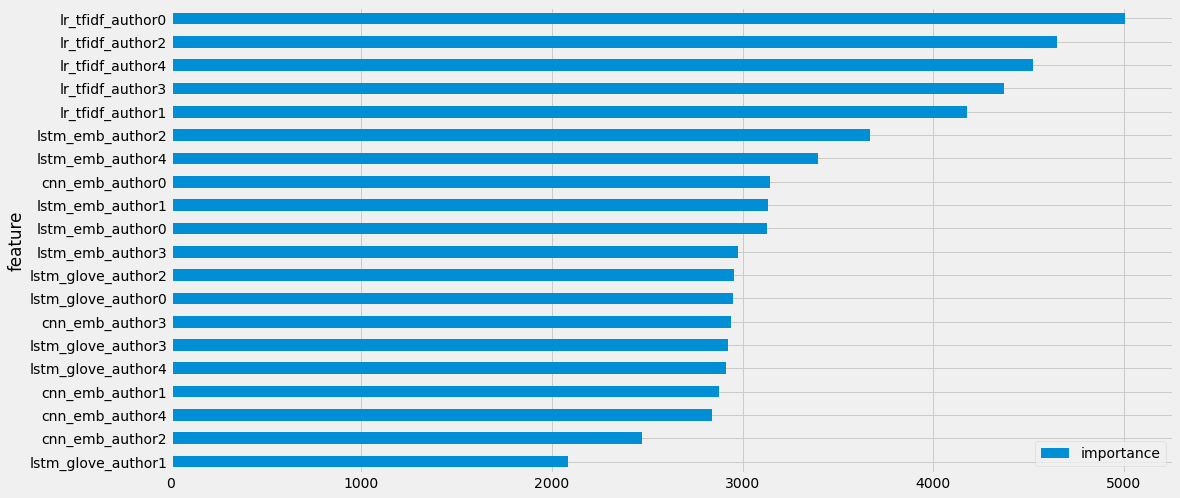

In [18]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [19]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [20]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0226,0.6734,0.2058,0.0922,0.0060
1,0.0430,0.9050,0.0035,0.0048,0.0436
2,0.9871,0.0033,0.0040,0.0010,0.0045
3,0.0053,0.0154,0.9181,0.0028,0.0583
4,0.4580,0.1921,0.0625,0.1228,0.1646


In [21]:
sub[sub.columns].value_counts()

0       1       2       3       4     
0.0122  0.0279  0.9363  0.0072  0.0164    2
0.0238  0.0158  0.9451  0.0025  0.0129    2
0.0091  0.0166  0.9193  0.0513  0.0037    2
0.2338  0.0264  0.6279  0.0126  0.0993    2
0.0016  0.0078  0.9843  0.0010  0.0053    2
                                         ..
0.1079  0.2884  0.0373  0.4508  0.1156    1
        0.0444  0.7040  0.0709  0.0728    1
        0.0039  0.0034  0.0088  0.8760    1
0.1081  0.2053  0.4426  0.2208  0.0233    1
0.0002  0.0002  0.0002  0.9993  0.0001    1
Length: 19604, dtype: int64

In [22]:
sub.to_csv(sub_file)